In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# A Tale of Two Time Scales: Determining Integrated Volatility With Noisy High-Frequency Data

This notebook aims to reproduce some of the results of the Monte-Carlo simulation of the paper from Lan Zhang, Per A. Mykland, and Yacine Ait-Sahalia.

In [3]:
# Setting global variables
S0 = 100.0  # Initial asset price
v0 = 0.04   # Initial volatility

# Parameters proposed by the paper
mu = .05
kappa = 5
alpha = .04
gamma = .5
rho = -.5
T = 1/252
Nsec = int(6.5 * 3600)
dt = T / Nsec

# Setting number of simulations
N_simulations = 2000

# Heston's volatility model

$$dX_t = (\mu - v_t/2)dt + \sigma_t dB_t$$
and 
$$dv_t = \kappa(\alpha - v_t)dt + \gamma v_t^{1/2} dW_t$$

where $v_t = \sigma_t^2$

In [4]:
def generate_brownians():
    ''' Generates pairs of Brownian motions with correlation rho
    '''
    dB = np.random.normal(0, np.sqrt(dt), (N_simulations, Nsec))
    dW = rho * dB + np.sqrt(1-rho**2) * np.random.normal(0, np.sqrt(dt), (N_simulations,Nsec))
    
    return dB, dW

def simulating_heston_price(M, n, S0, V0, T,  mu, kappa, theta, gamma, rho)-> np.array:
    
    
    # Simulating the Price 
    dB = rho * dW + np.sqrt(1 - rho**2) * np.random.normal(0, 1, (M, n))*np.sqrt(T/n)
    S = np.zeros((M, n+1))
    S[:, 0] = S0
    for i in range(n) :
        dS = mu * T/n + np.sqrt(V[:, i]) * dB[:, i]
        S[:, i+1] = S[:, i] * (1+dS)
        
    return S 

def generate_returns():
    ''' Generates the returns under the Heston volatility model
    '''
    X = np.zeros((N_simulations, Nsec))
    v = np.zeros((N_simulations, Nsec+1))

    dB, dW = generate_brownians()
    
    # Computing evolution of square of volatility
    v[:, 0] = v0
    a =  alpha * kappa
    for i in range(Nsec):
        v[:, i+1] = ((gamma * dW[:, i] + np.sqrt(gamma**2 * dW[:, i]**2 + 4 * (v[:, i] + (a - 0.5*gamma**2) * (T/Nsec)) * (1 + kappa* (T/Nsec)))) / (2 * (1 + kappa * (T/Nsec))))**2
    
       
    # Computing evolution of returns
    dX = (mu - v[:,1:]/2) * dt + np.sqrt(v[:,1:]) * dB
    X = dX.cumsum(axis = 1)
    
    return dX, X

# Visualizing returns

In [5]:
dX, X = generate_returns()

def get_Y(X: np.array) -> np.array:
    ''' Returns the Y with the noise from market microstructure
    '''
    nrows, ncols = X.shape
    noise = np.random.normal(0, 5*1e-4, (nrows, ncols))
    return X + noise

Y = get_Y(X)

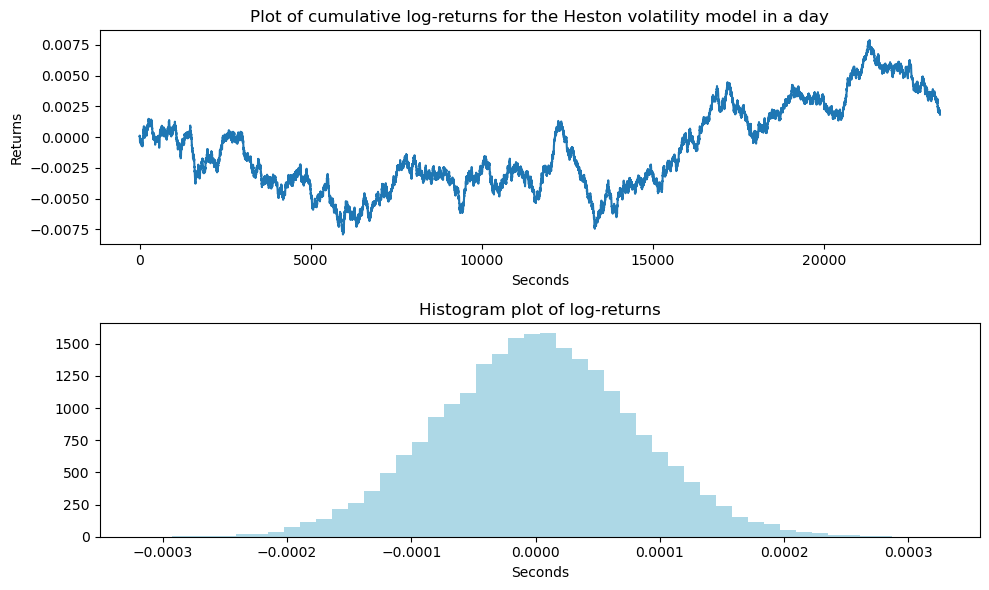

In [6]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# First subplot: Plot of cumulative log-returns
axes[0].plot(np.arange(Nsec), X[0, :])
axes[0].set_title("Plot of cumulative log-returns for the Heston volatility model in a day")
axes[0].set_ylabel('Returns')
axes[0].set_xlabel('Seconds')

# Second subplot: Histogram plot of log-returns
axes[1].hist(dX[0, :], bins=50, color='lightblue')
axes[1].set_title('Histogram plot of log-returns')
axes[1].set_xlabel('Seconds')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

# Implementing estimators of $<X, X>_T$

In [7]:
# Real value of <X, X>_T

def true_volatility(dX: np.array) -> float:
    ''' Returns the true volatility
    '''
    return np.square(dX).sum(axis = 1)

**1- Fifth Best Estimator** $[Y, Y]_T^{(all)}$ :

The naïve estimator of quadratic variation is $[Y,Y]^{(all)}_T$,
which is the realized volatility based on the entire sample

$$[Y, Y]_T^{(all)} =  \large\sum_{i=0}^{n-1} (Y_{t_{i+1}} - Y_{t_i})^2 $$

In [8]:
def fifth_best_estimator(Y: np.array) -> float:
    ''' Implements the fifth best estimator. It simply compute the sum
    of the squares of the log returns.
    '''
    dY = np.diff(Y, axis = 1)
    return np.square(dY).sum(axis = 1)

**2- Fourth Best Estimator** $[Y, Y]_T^{(sparse)}$ : **Sampling Sparsely at Some Lower Frequency.**

Taking only only a number of observations, for example an observation each 5 minutes, and computing the quadratic variation.

$$0 \le t_{i_1} < ... <t_{i_{n_{sparse}}} = T$$
$$[Y, Y]_T^{(sparse)} =  \large\sum_{j=1}^{n_{sparse}-1} (Y_{t_{i_j}} - Y_{t_{i_{j+1}}})^2 $$

In [9]:
def fourth_best_estimator(Y: np.array, n_sparse: int) -> float:
    ''' Same as fifth but samples sparsely on the log returns
    '''
    dY = np.diff(Y, axis = 1)
    step = Nsec // n_sparse
    
    return np.square(dY[:,::step]).sum(axis = 1)
    

**2- Third Best Estimator** $[Y, Y]_T^{(sparse, opt)}$ : **Sampling Sparsely at an Optimally Determined Frequency.**

We choose an optimal frequency of sampling, which is $$n_{sparse}^* = \left( \frac{T}{4*E(\epsilon^2)} \int_{0}^{T} \sigma_t^4 dt \right)$$

We take an observation each $step = TotalNumberObservations / n_{sparse}^*$

To compute $n_{sparse}^*$ , we will need to estimate $E(\epsilon^2)$ and  $vol4 = \int_{0}^{T} \sigma_t^4 dt$


- Estimating $E(\epsilon^2)$

$$\widehat{E(\epsilon^2)} = \frac{1}{2n} [Y, Y]_T^{(all)}$$


In [10]:
def get_e2(Y: np.array) -> np.array:
    ''' Returns an estimation of E[eps^2]
    '''
    noise2 = (1/(2*Nsec)) * fifth_best_estimator(Y)
    return noise2

- Estimating  integrated quarticity (IQ) $ \int_{0}^{T} \sigma_t^4 dt$ - This estimator is proposed on section 6 of the paper

$$IQ = \widehat{\int_{0}^{T} \sigma_t^4 dt} = \frac{\hat{s}_0^2 - 8E(\epsilon^2)^2 c_1^{-2} (1 + I^{-2} - I^{-1})}{c_1(I^{1/2} - 1)T}$$

where $$\hat{s}_0^2 = n^{1/3} \large \sum_{m=1}^{M-1} \left( (\langle X, X \rangle^{K_1} _{T_{m+1}} - \langle X, X \rangle^{K_1} _{T_{m}}) - (\langle X, X \rangle^{K_2} _{T_{m+1}} - \langle X, X \rangle^{K_2} _{T_{m}}) \right)^2$$


In [11]:
def estimation_vol4(Y: np.array) -> np.array:
    ''' Returns an estimation int 0_T (sigma_t^4), based on the proposed estimator in section 6 of the article
    '''
    
    M = 100 #  We devide the segment [0, T] to M segments of larger T/M
    
    c_1 = 1  
    K_1 = int(c_1 * Nsec**(2/3))
    
    I = 3
    c_2 = I * c_1
    K_2 = int(c_2 * Nsec**(2/3))
  
    s2_0 = np.zeros(Y.shape[0])
    
    dY = np.diff(Y, axis = 1)
    fifth_estimators = np.square(dY).cumsum(axis =1) # this compute the fifth best estimators for each interval 0 to k*T/Nsec
    
    estimator_K1 = Avereging_and_bias_correction(Y, K_1, Nsec//M, fifth_estimators[:, Nsec//M-2])
    estimator_K2 = Avereging_and_bias_correction(Y, K_2, Nsec//M, fifth_estimators[:, Nsec//M-2]) 
    for m in range(2, M+1):
        estimator_K1_next = Avereging_and_bias_correction(Y, K_1, m*Nsec//M, fifth_estimators[:, m*Nsec//M-2]) 
        estimator_K2_next = Avereging_and_bias_correction(Y, K_2, m*Nsec//M, fifth_estimators[:, m*Nsec//M-2]) 
        
        s2_0 = s2_0 + ((estimator_K1_next - estimator_K1) - (estimator_K2_next - estimator_K2))**2 
        
        estimator_K1 = estimator_K1_next
        estimator_K2 = estimator_K2_next
        
    s2_0 = Nsec**(1/3) * s2_0
    
    e2 = get_e2(Y)
    eta = s2_0 - 8 * e2**2 * c_1**(-2) * (1+I**(-2)-I**(-1)) 
    eta = eta / (c_1 * (I**0.5 - 1)**2 * T)
    
    vol4 = 3/4 * eta
    
    return vol4


def Avereging_and_bias_correction(Y : np.array,  K : int , N : int, fifth_estimator : np.array = np.NAN) -> float :
    """ Return the estimator of <X, X> on the grid defined by K, and for an horizon of N seconds,
    The estimator used is, the bias correction estimator, using both average estimator and the fifth estimator.
    """
    if  len(fifth_estimator) == 0 :
        fifth_estimator = fifth_best_estimator(Y)
    
    estimator = np.zeros(Y.shape[0])
    for i in range(K):
        estimator += np.square(np.diff(Y[:, i:N:K])).sum(axis=1)
    estimator /= K
    
    n_bar = N / K

    bias_correction = (n_bar / N) * fifth_estimator
    
    estimator = estimator - bias_correction
    
    return estimator

In [12]:
estimated_vol4 = estimation_vol4(Y)

def get_vol4() :
    print(estimated_vol4.mean())
    return estimated_vol4

In [13]:
def third_best_estimator(Y: np.array, vol4 : float = get_vol4()) -> float:
    ''' Applies the fourth best estimator using the best step
    Estimation of noise is discussed in page 5 of the paper.
    '''
    e2 = get_e2(Y)

    n_sparse_optimal = np.round(((T/4)*(vol4/e2**2))**(1/3)).astype('int')
    
    estimator = np.zeros(Y.shape[0])
    
    dY = np.diff(Y, axis = 1)
    steps = Nsec // n_sparse_optimal
    for k in range(Y.shape[0]):
        estimator[k] = np.square(dY[k, ::max(1, steps[k])]).sum()
    return estimator
   

5.658365485596525e-06


**4- Second Best Estimator** $[Y, Y]_T^{(avg)}$ : **Subsampling and Averaging.**

this third estimator constructed by averaging the estimators $[Y,Y]_T^{(k)}$ across K grids of average size $\bar{n}$.

$$[Y, Y]_T^{(avg)}  = \frac{1}{K} \large \sum_{k=1}^{K} [Y,Y]_T^{(k)}$$

Where $$[Y,Y]_T^{(k)} = \sum_{i=0}^{n/K} (Y_{t_{k+i(K+1)}} - Y_{t_{k+iK}})^2 $$

To compute $n_{sparse}^*$ , we will need to estimate $E(\epsilon^2)$ and  $\int_{0}^{T} \sigma_t^4 dt$

In [14]:
def second_best_estimator(Y: np.array, optimal : bool, K: np.array = np.NAN, vol4 : float = get_vol4()) -> np.array:
    ''' Split the data in K grids, with each one being composed of 
    i, i+K, i+2K, ... i going from 1 to K.
    If no value of K is passed the optimal value is computed.
    '''
    if optimal :
        e2 = get_e2(Y)
        n_star = np.round((T*vol4/(6*e2**2))**(1/3)).astype('int')
        K = Nsec // n_star
           
    estimator = np.zeros(Y.shape[0])
    for j in range(Y.shape[0]) :
        k = max(int(K[j]), 1)
        for i in range(k):
            estimator[j] += np.square(np.diff(Y[j, i::k])).sum()
        estimator[j] /= k
        
    return estimator

5.658365485596525e-06


**5- First Best Estimator** $ \widehat{\langle X, X\rangle}^{(adj)} $ : **Subsampling and Averaging, and Bias-Correction.**

$$ \widehat{\langle X, X\rangle}^{(adj)}  = (1-\frac{\bar{n}}{n}) \left([Y, Y]_T^{(avg)} - \frac{\bar{n}}{n}[Y, Y]_T^{(all)} \right)$$

In [15]:
def first_best_estimator(Y: np.array, vol4 : float = get_vol4()) -> float:
    '''Implements best estimator proposed by the paper
        
    '''
    e2 = get_e2(Y)
    
    c_star = ((T/12) * vol4 / e2**2)**(-1/3)
    K_star = c_star * Nsec**(2/3)
    
    n_bar =  (Nsec - K_star + 1) // K_star 
    
    return (1 - (n_bar / Nsec)) * (second_best_estimator(Y, False, K_star) - (n_bar / Nsec) * fifth_best_estimator(Y))

5.658365485596525e-06


# Analyzing the performance of each estimator

In [20]:
estimators_name = ['metric', 'Fifth-best, [Y, Y]_all', 'Fourth-best, [Y, Y]_sparse', 'Third-best, [Y, Y]_sparse_opt', 'Second-best, [Y,Y]_avg', 'First-best, [Y,Y]_adj']
df = pd.DataFrame(columns=estimators_name)
df['metric'] = np.array(['small-sample bias', 'small-sample std', 'small-sample RMSE', 'small-sample relative bias', 'small-sample relative variance', 'small-sample relative RMSE'])

true_vol = true_volatility(dX)

def metrics(estimator : np.array) -> np.array :
    bias = np.mean(estimator - true_vol)
    std = np.mean(np.std(estimator - true_vol))
    RMSE = (np.square(estimator-true_vol)).mean()**0.5
    relative_bias = np.mean((estimator - true_vol)/true_vol)
    relative_var =  np.mean(np.var((estimator - true_vol)/true_vol))
    relative_RMSE = (np.square((estimator-true_vol)/true_vol)).mean()**0.5
    
    return np.array([bias, std, RMSE, relative_bias, relative_var, relative_RMSE])

fifth  = fifth_best_estimator(Y)
fourth = fourth_best_estimator(Y, n_sparse= Nsec//10)
third  = third_best_estimator(Y)
second = second_best_estimator(Y, True, K=np.NAN)
first  = first_best_estimator(Y)

In [21]:
df.iloc[:, 1] = metrics(fifth)
df.iloc[:, 2] = metrics(fourth)
df.iloc[:, 3] = metrics(third)
df.iloc[:, 4] = metrics(second)
df.iloc[:, 5] = metrics(first)
df

,metric,"Fifth-best, [Y, Y]_all","Fourth-best, [Y, Y]_sparse","Third-best, [Y, Y]_sparse_opt","Second-best, [Y,Y]_avg","First-best, [Y,Y]_adj"
0,small-sample bias,0.011704,0.001027,-0.000136,0.000011,-0.000003
1,small-sample std,0.000136,0.000037,0.000014,0.000032,0.000009
2,small-sample RMSE,0.011704,0.001028,0.000137,0.000034,0.00001
3,small-sample relative bias,74.405751,6.536791,-0.860181,0.071141,-0.021883
4,small-sample relative variance,47.315819,0.520994,0.001532,0.041699,0.003342
5,small-sample relative RMSE,74.723032,6.576521,0.861071,0.216242,0.061812


## RMSE of the Sparse Estimator as a Function of the Subsampling Frequency

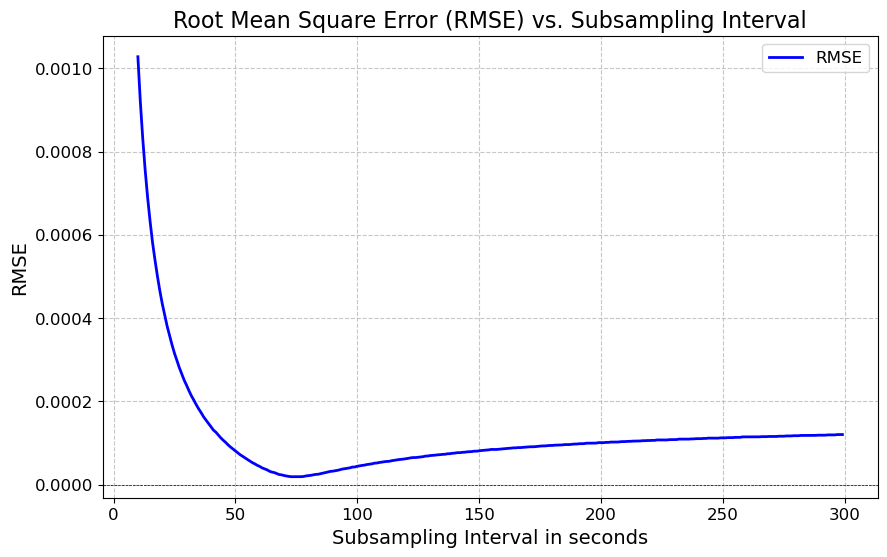

In [218]:
subsampling_interval = np.arange(10, 60*5)  # Concatenate the two ranges

RMSE = np.zeros(len(subsampling_interval))

for k in range(len(subsampling_interval)):
    step = subsampling_interval[k]
    n_sparse = Nsec // step
    RMSE[k] = (np.square(fourth_best_estimator(Y, n_sparse) - true_vol)).mean()**(0.5)


plt.figure(figsize=(10, 6))  # Adjust the figure size

# Plot the RMSE curve
plt.plot(subsampling_interval, RMSE, '-', label='RMSE', linewidth=2, color='blue')

# Add labels and a legend
plt.xlabel('Subsampling Interval in seconds', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('Root Mean Square Error (RMSE) vs. Subsampling Interval', fontsize=16)
plt.legend(fontsize=12)

# Customize the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Show plot
plt.show()

# Black-Scholes model

The formula for the Black Scholes model is simply a geometric Brownian motion:

$$
dS_{t} = \mu S_{t} dt + \sigma S_{t} dW_{t}
$$

$$
dX_{t} = (\mu - \frac{1}{2} \sigma^2) dt + \sigma dW{t}
$$

We we will simulate by discretizing in the same way we did with the Heston model.

In [239]:
## Black Scholes Parameters

sigma = 0.04

mu = 0.05
theoretical_integrated_vol = sigma**2 * T

def generate_returns_black_scholes():
    ''' Generates the returns under the Black-Scholes model
    '''
    
    S = np.zeros((N_simulations, Nsec+1))
    S[:, 0] = S0

    dW = np.random.normal(0, np.sqrt(dt), (N_simulations, Nsec))
    
    for i in range(Nsec):
        dS = mu * dt + sigma * dW[:, i]
        S[:, i+1] = S[:, i] * np.exp(dS)

    dX = (mu - 1/2 * sigma**2) *dt + sigma * dW
    
    X = np.cumsum(dX, axis = 1)

    return S, dX, X

In [240]:
S, dX, X = generate_returns_black_scholes()

## Price evolution under Black-Scholes

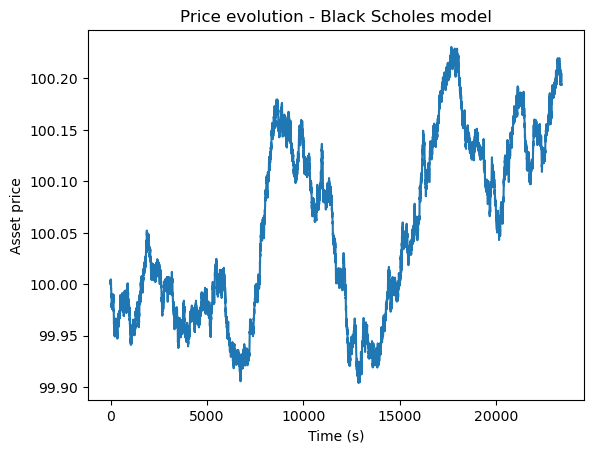

In [241]:
plt.plot(np.arange(S.shape[1]),S[-1,:])
plt.title('Price evolution - Black Scholes model')
plt.xlabel('Time (s)')
plt.ylabel('Asset price')
plt.show()

**Using the article proposed estimator of the integrated Quarticity int_0^T sigma_t^4 dt**

In [248]:
Y = get_Y(X)
#estimated_vol4 = estimation_vol4(Y) ## Using the article estimator of int_0_T sigma ** 4

# fifth_vol_estimator_bs = fifth_best_estimator(Y)
# fourth_vol_estimator_bs = fourth_best_estimator(Y, Nsec//10)
# third_vol_estimator_bs = third_best_estimator(Y)
# second_vol_estimator_bs = second_best_estimator(Y, True, K=np.NAN)
# first_vol_estimator_bs = first_best_estimator(Y)

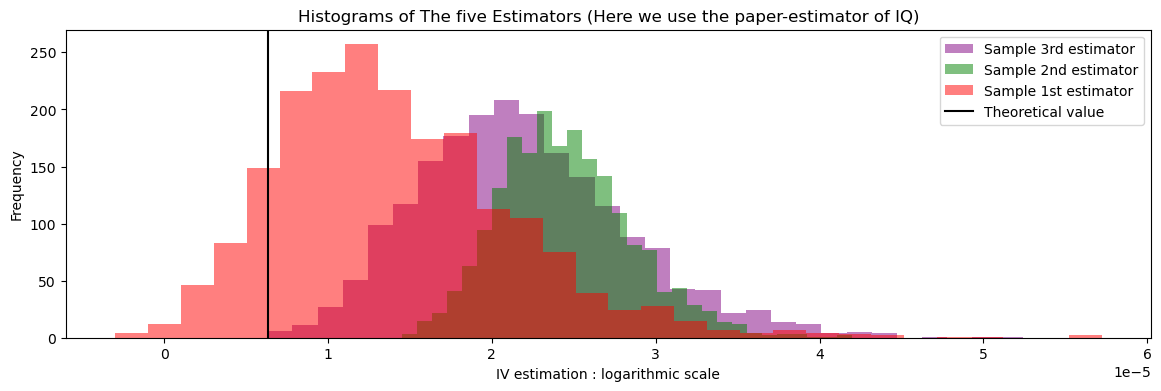

In [223]:
estimators = [fifth_vol_estimator_bs, fourth_vol_estimator_bs, third_vol_estimator_bs, second_vol_estimator_bs, first_vol_estimator_bs]
Labels = ['Sample 5th estimator', 'Sample 4th estimator', 'Sample 3rd estimator','Sample 2nd estimator','Sample 1st estimator']
colors = ['blue', 'green', 'purple', 'green', 'red']
# Plotting the histograms
plt.figure(figsize=(14, 4))

for k in range(2, 5):
    plt.hist(estimators[k], bins = 30, label = Labels[k], alpha = 0.5, color=colors[k])

plt.axvline(theoretical_integrated_vol, label = 'Theoretical value', color = 'black')

plt.legend()
plt.xscale('linear')
plt.title('Histograms of The five Estimators (Here we use the paper-estimator of IQ)')
plt.xlabel('IV estimation : logarithmic scale')
plt.ylabel('Frequency')
plt.show()

In [224]:
real_vol4 = sigma**4 * T * np.ones(N_simulations)

print("The absolute relative error of estimation of int_0_T sigma_t^4 = ", abs((estimated_vol4 - real_vol4)/real_vol4).mean()**0.5)

The absolute relative error of estimation of int_0_T sigma_t^4 =  0.6522055923290894


**Estimating   integrated quarticity (IQ) $\int_{0}^{T} \sigma_t^4 dt$ using a low frequency** 
$$IQ =  \frac{n_{sparse}}{3}\large\sum_{j=0}^{n_{sparse}-1} (Y_{t_{i_j}} - Y_{t_{i_{j+1}}})^4 $$

In [196]:
def IQ(Y : np.array):
    step = 5 * 60 # each five minutes
    n_sparse = Nsec // step
    
    dY_4 = np.diff(Y[:, ::step])**4.0
    
    return n_sparse * 1/3 * dY_4.sum(axis=1)

estimated_vol4 = IQ(Y)

print("The absolute relative error of estimation of IQ = ", abs((estimated_vol4 - real_vol4)/real_vol4).mean()**0.5)

The absolute relative error of estimation of IQ =  0.8922311555402621


In [197]:
fifth_vol_estimator_bs_IQ = fifth_best_estimator(Y)
fourth_vol_estimator_bs_IQ = fourth_best_estimator(Y, Nsec//10)
third_vol_estimator_bs_IQ = third_best_estimator(Y)
second_vol_estimator_bs_IQ = second_best_estimator(Y, True, K=np.NAN)
first_vol_estimator_bs_IQ = first_best_estimator(Y)

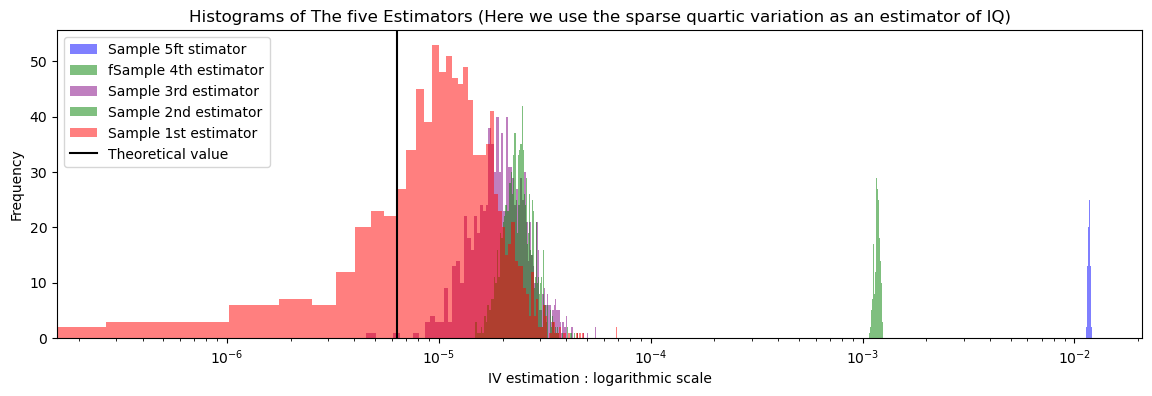

In [198]:
Labels = ['Sample 5ft stimator', 'fSample 4th estimator','Sample 3rd estimator','Sample 2nd estimator','Sample 1st estimator']
estimators = [fifth_vol_estimator_bs_IQ, fourth_vol_estimator_bs_IQ, third_vol_estimator_bs_IQ, second_vol_estimator_bs_IQ, first_vol_estimator_bs_IQ]

plt.figure(figsize=(14, 4))
for k in range(5) :
    plt.hist(estimators[k], bins = 100, label = Labels[k], alpha = 0.5, color=colors[k])
plt.axvline(theoretical_integrated_vol, label = 'Theoretical value', color = 'black')


plt.legend()
plt.xscale('log')
plt.title('Histograms of The five Estimators (Here we use the sparse quartic variation as an estimator of IQ)')
plt.xlabel('IV estimation : logarithmic scale')
plt.ylabel('Frequency')
plt.show()

**Effect of using the real value of $\int_{0}^{T} \sigma_t^4 dt$**

The third, the Second and the first estimators use the value of $\int_{0}^{T} \sigma_t^4 dt$ to construct the estimator. In our previous simulation, we estimated this stochastic integral using the estimator of the article proposed in section 6. (see estimation of $\eta$)

In the next simulation, we will use the theorical value of the $\int_{0}^{T} \sigma_t^4 dt$ which equal to $\sigma^4 * T$ for BS model, this will show the effect of the estimation of the integral on the perfomance of these three estimators.

In [199]:
fifth_vol_estimator_bs_realvol4 =  fifth_best_estimator(Y)
fourth_vol_estimator_bs_realvol4=  fourth_best_estimator(Y, Nsec//10)
third_vol_estimator_bs_realvol4 = third_best_estimator(Y, vol4=real_vol4)
second_vol_estimator_bs_realvol4 = second_best_estimator(Y, True, K=np.NAN, vol4=real_vol4)
first_vol_estimator_bs_realvol4 = first_best_estimator(Y, vol4= real_vol4)

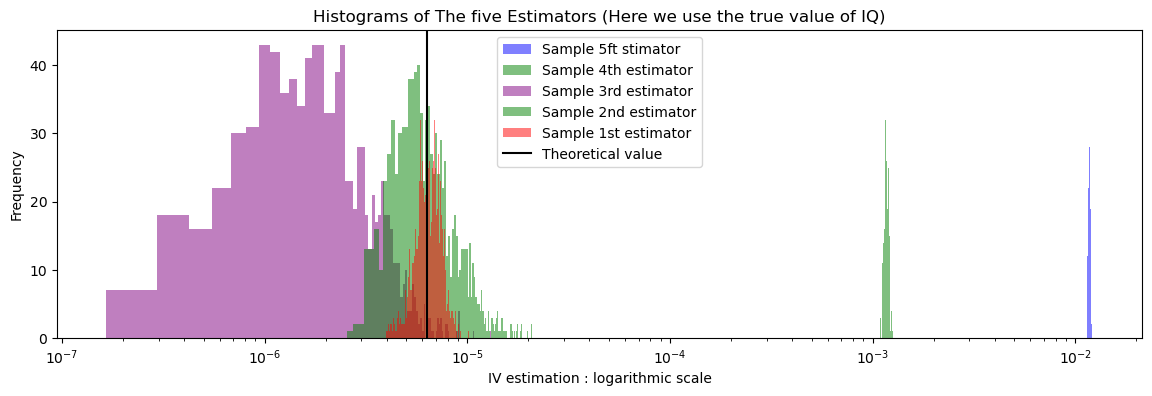

In [200]:
Labels = ['Sample 5ft stimator', 'Sample 4th estimator','Sample 3rd estimator','Sample 2nd estimator','Sample 1st estimator']
estimators = [fifth_vol_estimator_bs_realvol4, fourth_vol_estimator_bs_realvol4, third_vol_estimator_bs_realvol4, second_vol_estimator_bs_realvol4, first_vol_estimator_bs_realvol4]
plt.figure(figsize=(14, 4))
for k in range(5) :
    plt.hist(estimators[k], bins = 100, label = Labels[k], alpha = 0.5, color=colors[k])
plt.axvline(theoretical_integrated_vol, label = 'Theoretical value', color = 'black')


plt.legend()
plt.xscale('log')
plt.title('Histograms of The five Estimators (Here we use the true value of IQ)')
plt.xlabel('IV estimation : logarithmic scale')
plt.ylabel('Frequency')
plt.show()